In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.decomposition import PCA, KernelPCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
def print_report(clf, X_test, y_test):
    y_true, y_pred = y_test, clf.predict(X_test)

    print(
        classification_report(y_true, y_pred, labels=np.unique(y_true), zero_division=0)
    )

    df_cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        columns=np.unique(y_test),
        index=np.unique(y_test),
    )

    sns.heatmap(
        df_cm,
        square=True,
        annot=True,
        # fmt="d",
        cbar=False,
    )
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.show()

    print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))


def cv_results_df(clf):
    results_df = pd.concat(
        [
            pd.DataFrame(
                {
                    "mean_accuracy": clf.cv_results_["mean_test_accuracy"],
                    "std_accuracy": clf.cv_results_["std_test_accuracy"],
                    "mean_f1_macro": clf.cv_results_["mean_test_f1_macro"],
                    "std_f1_macro": clf.cv_results_["std_test_f1_macro"],
                }
            ),
            pd.DataFrame(clf.cv_results_["params"]),
        ],
        axis=1,
    )

    return results_df

In [3]:
winequality_data = pd.read_csv("winequality-white.csv").dropna()

winequality_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [4]:
winequality_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [5]:
y = winequality_data["quality"]
X = winequality_data.loc[:, winequality_data.columns != "quality"]

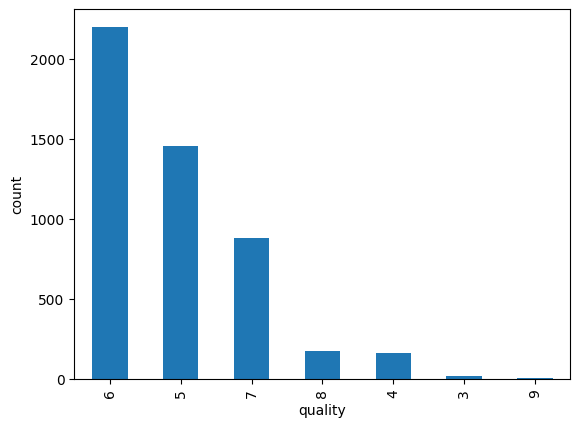

In [6]:
y.value_counts().plot(kind="bar")
plt.xlabel("quality")
plt.ylabel("count")
plt.show()

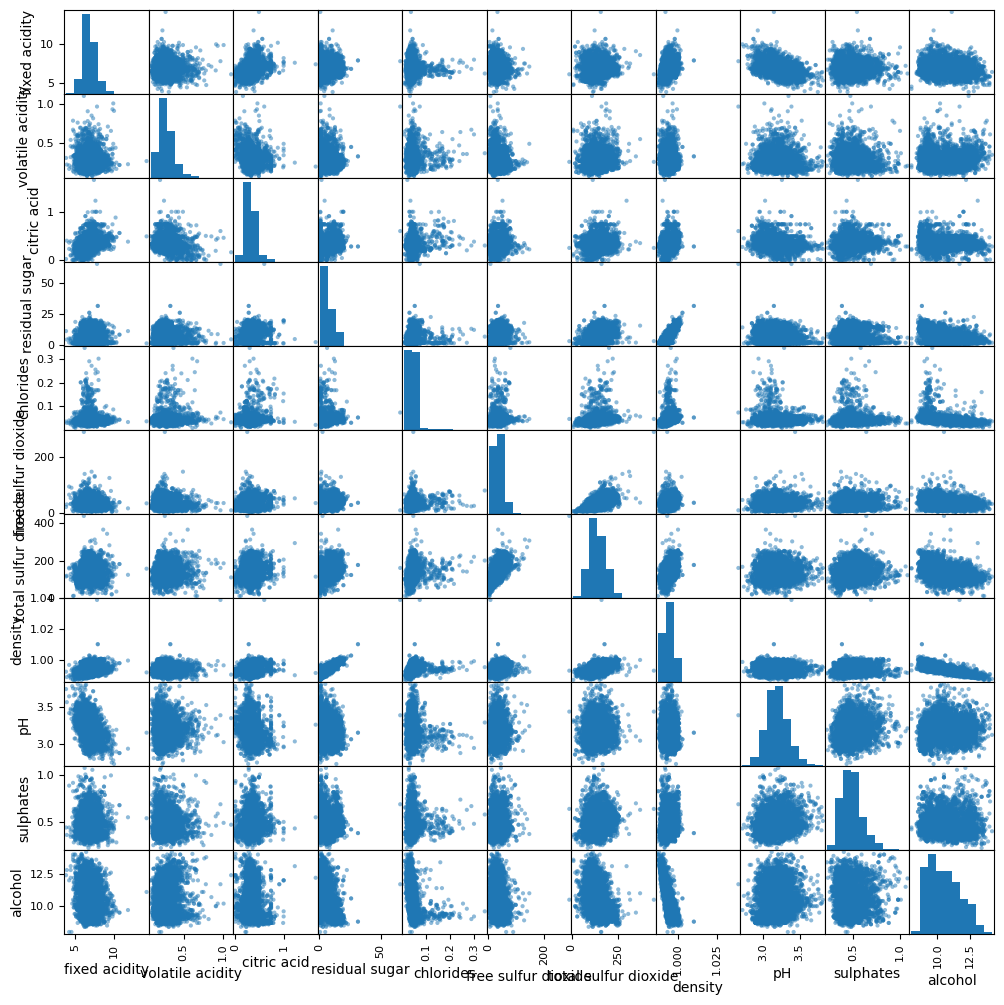

In [7]:
pd.plotting.scatter_matrix(X, figsize=(12, 12))
plt.show()

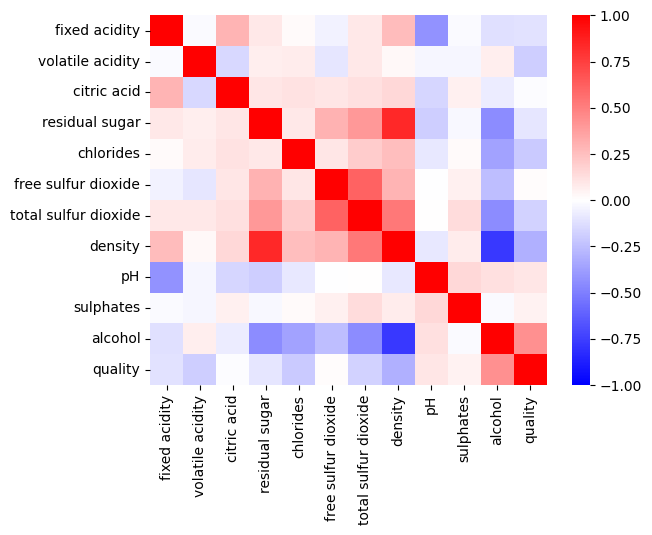

In [8]:
sns.heatmap(winequality_data.corr(), cmap="bwr", vmin=-1, vmax=1)

plt.show()

In [9]:
seed = 11
test_pct = 0.20
grid_kwargs = {
    "cv": 3,
    "n_jobs": -1,
    "scoring": ["accuracy", "f1_macro"],
    "refit": "accuracy",
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_pct, random_state=seed
)

## Support Vector Classifier

best combination:
	 {'C': 1000, 'kernel': 'rbf'} 



,mean_accuracy,std_accuracy,mean_f1_macro,std_f1_macro,C,kernel
0,0.452782,0.001910,0.109730,0.000294,1,rbf
1,0.405564,0.026980,0.143650,0.004143,1,sigmoid
2,0.464778,0.006345,0.140485,0.025633,10,rbf
3,0.389484,0.035102,0.151203,0.017927,10,sigmoid
4,0.506381,0.008488,0.173780,0.014323,100,rbf
5,0.384635,0.037031,0.139914,0.004057,100,sigmoid
6,0.520163,0.009067,0.186913,0.024817,1000,rbf
7,0.383614,0.036838,0.139809,0.003635,1000,sigmoid


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.50      0.03      0.05        37
           5       0.56      0.62      0.59       282
           6       0.52      0.79      0.62       435
           7       0.00      0.00      0.00       186
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00         2

    accuracy                           0.53       980
   macro avg       0.23      0.20      0.18       980
weighted avg       0.41      0.53      0.45       980



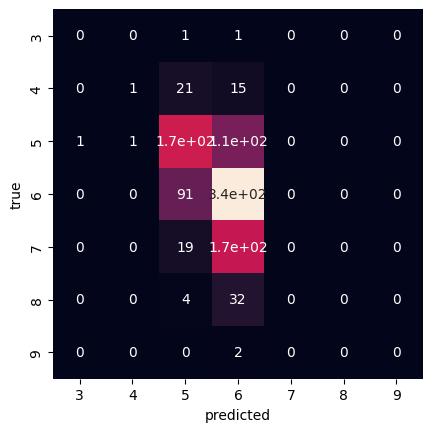

Cohen Kappa Score: 0.22475671761397087


In [10]:
hyperparams = {"C": [1, 10, 100, 1000], "kernel": ["rbf", "sigmoid"]}

svc_clf = GridSearchCV(SVC(random_state=seed), param_grid=hyperparams, **grid_kwargs)
svc_clf.fit(X_train, y_train)

print(f"best combination:")
print("\t", svc_clf.best_params_, "\n")

display(cv_results_df(svc_clf))

print_report(svc_clf, X_test, y_test)

## Support Vector Classifier w/ PCA

best combination:
	 {'pca__n_components': None, 'standardscaler': MinMaxScaler()} 



,mean_accuracy,std_accuracy,mean_f1_macro,std_f1_macro,pca__n_components,standardscaler
0,0.574017,0.008325,0.353636,0.011703,NaN,StandardScaler()
1,0.576570,0.009336,0.355222,0.006665,NaN,MinMaxScaler()
2,0.538540,0.014068,0.253797,0.015214,NaN,None
3,0.485707,0.003663,0.214416,0.000978,3.0,StandardScaler()
4,0.485707,0.005243,0.213272,0.013031,3.0,MinMaxScaler()
5,0.461205,0.008534,0.157229,0.021259,3.0,None
6,0.539561,0.001805,0.321499,0.006112,6.0,StandardScaler()
7,0.532159,0.009017,0.317751,0.007381,6.0,MinMaxScaler()
8,0.517101,0.019931,0.235884,0.013132,6.0,None


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.28      0.24      0.26        37
           5       0.59      0.67      0.63       282
           6       0.68      0.64      0.66       435
           7       0.61      0.60      0.60       186
           8       0.46      0.44      0.45        36
           9       0.00      0.00      0.00         2

    accuracy                           0.62       980
   macro avg       0.37      0.37      0.37       980
weighted avg       0.62      0.62      0.61       980



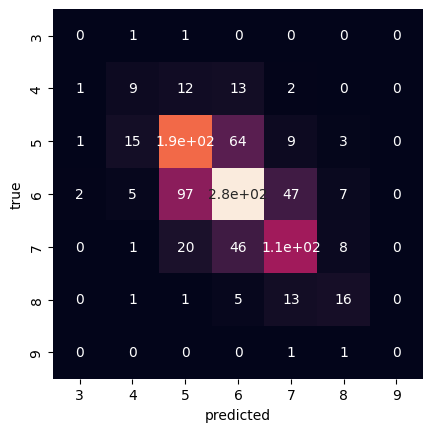

Cohen Kappa Score: 0.43783826552426686


In [11]:
svc_pipe = make_pipeline(
    StandardScaler(),
    PCA(random_state=seed),
    SVC(**svc_clf.best_params_, random_state=seed),
)

hyperparams = {
    "standardscaler": [StandardScaler(), MinMaxScaler(), None],
    "pca__n_components": [None, 3, 6],
}

clf = GridSearchCV(svc_pipe, param_grid=hyperparams, **grid_kwargs)

clf.fit(X_train, y_train)

print(f"best combination:")
print("\t", clf.best_params_, "\n")

display(cv_results_df(clf))

print_report(clf, X_test, y_test)

### Discussion

The final accuracy of the tuned SVM is 0.62 and a CK of 0.44. From the cross-validation on the pipeline, the SVM performs best by first applying the `MinMaxScaler` to the training data set, and then using the `rbf` kernel with minimal regularization (`C = 1000`).

Dimensionality reduction from PCA didn't save too much on computational time, so it's probably not necessary here. However, selecting 6 out of 12 features results in a very small (~3-4%) reduction in accuracy.

## Random Forest Classifier

best combination:
	 {'classifier': RandomForestClassifier(random_state=11)} 



,mean_accuracy,std_accuracy,mean_f1_macro,std_f1_macro,classifier
0,0.556406,0.015139,0.341454,0.025949,DecisionTreeClassifier(random_state=11)
1,0.640888,0.003481,0.407500,0.027723,HistGradientBoostingClassifier(random_state=11)
2,0.652118,0.004523,0.401324,0.019315,RandomForestClassifier(random_state=11)


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.57      0.22      0.31        37
           5       0.73      0.71      0.72       282
           6       0.67      0.83      0.74       435
           7       0.82      0.59      0.69       186
           8       0.89      0.44      0.59        36
           9       0.00      0.00      0.00         2

    accuracy                           0.71       980
   macro avg       0.53      0.40      0.44       980
weighted avg       0.72      0.71      0.70       980



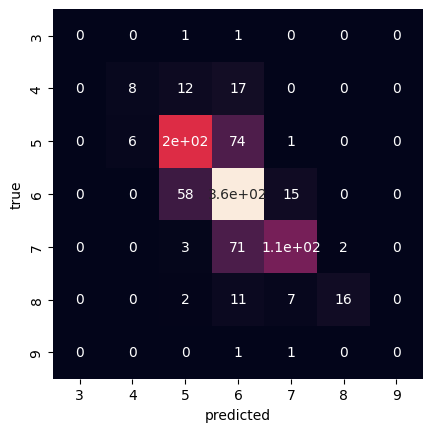

Cohen Kappa Score: 0.554546170019001


In [12]:
pipe = Pipeline([("classifier", None)])

hyperparams = {
    "classifier": [
        DecisionTreeClassifier(random_state=seed),
        HistGradientBoostingClassifier(random_state=seed),
        RandomForestClassifier(random_state=seed),
    ],
}

dt_clf = GridSearchCV(pipe, param_grid=hyperparams, **grid_kwargs)

dt_clf.fit(X_train, y_train)

print(f"best combination:")
print("\t", dt_clf.best_params_, "\n")

display(cv_results_df(dt_clf))

print_report(dt_clf, X_test, y_test)

best combination:
	 {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 100} 



,mean_accuracy,std_accuracy,mean_f1_macro,std_f1_macro,criterion,max_depth,max_features,n_estimators
0,0.462736,0.017687,0.103753,0.021287,gini,1,sqrt,10
1,0.450230,0.000000,0.088924,0.000316,gini,1,sqrt,100
2,0.462736,0.017687,0.103753,0.021287,gini,1,log2,10
3,0.450230,0.000000,0.088924,0.000316,gini,1,log2,100
4,0.486217,0.011114,0.158916,0.002873,gini,1,None,10
...,...,...,...,...,...,...,...,...
175,0.657223,0.003443,0.385660,0.010277,log_loss,46,sqrt,100
176,0.630168,0.004376,0.378622,0.007661,log_loss,46,log2,10
177,0.657223,0.003443,0.385660,0.010277,log_loss,46,log2,100
178,0.626340,0.000625,0.375031,0.008969,log_loss,46,None,10


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.55      0.16      0.25        37
           5       0.71      0.71      0.71       282
           6       0.67      0.80      0.73       435
           7       0.77      0.63      0.69       186
           8       0.94      0.42      0.58        36
           9       0.00      0.00      0.00         2

    accuracy                           0.70       980
   macro avg       0.52      0.39      0.42       980
weighted avg       0.70      0.70      0.69       980



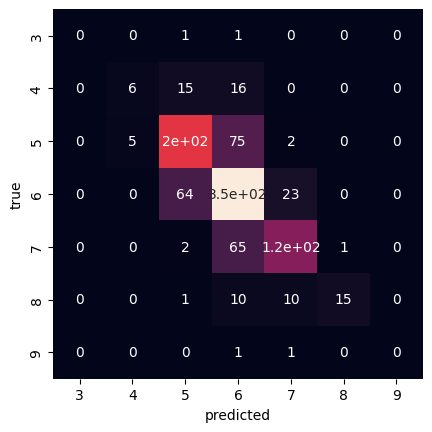

Cohen Kappa Score: 0.541681098535212


In [13]:
selected_model = RandomForestClassifier(random_state=seed)

hyperparams = {
    "n_estimators": [10, 100],
    "max_depth": range(1, 50, 5),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2", None],
}


rf_clf = GridSearchCV(selected_model, param_grid=hyperparams, **grid_kwargs)
rf_clf.fit(X_train, y_train)

print(f"best combination:")
print("\t", rf_clf.best_params_, "\n")

display(cv_results_df(rf_clf))

print_report(rf_clf, X_test, y_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00       282
           6       0.44      1.00      0.61       435
           7       0.00      0.00      0.00       186
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00         2

    accuracy                           0.44       980
   macro avg       0.06      0.14      0.09       980
weighted avg       0.20      0.44      0.27       980



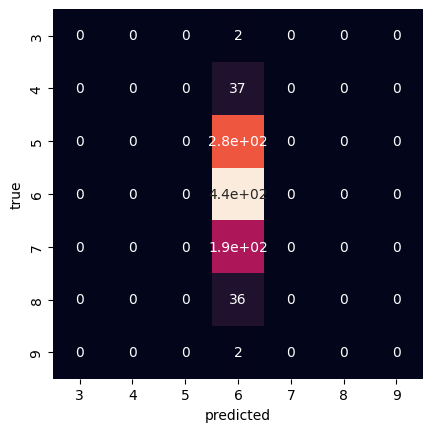

Cohen Kappa Score: 0.0


In [14]:
dummy = DummyClassifier()

dummy_res = dummy.fit(X_train, y_train)

print_report(dummy_res, X_test, y_test)

# Discussion 2

The tuned `RandomForestClassifer` performed better than the SVM with a final accuracy of 0.70 and CK 0.54.
Comparing to the DummyClasifier, which has an accuracy of 0.44, clearly performed much worse, but only made predictions of WineQuality 6.
The RF was able to predict the majority of the class 6 without confusion, however, made 0 predictions for classes 3 and 9, confusing them for other classifications. Maybe this is due to imbalance in the dataset, overrepresentation of class 6, under representation of classes 3 and 9.